*** Work in Progress ***

Pubmed Query Builder: https://pubmed.ncbi.nlm.nih.gov/advanced/

### Notes
* Dates stored in __repr__ format in JSON
* 000 = Code for unobtainable PMUID

### MeSH Terms
* Biomedical Engineering 
* Biomedical Technology
* Equipment Safety
* Equipment Design
* Prostheses and Implants

### Querys
(("Equipment and Supplies"[MeSH Terms] OR "Equipment Design"[MeSH Terms] OR "Equipment Safety"[MeSH Terms] OR "Biomedical Technology"[MeSH Terms] OR "Biomedical Engineering"[MeSH Terms]) AND 1850/01/01:1997/12/31[Date - Publication]) AND (English[Language])

(((medical device[Title/Abstract]) OR (medical devices[Title/Abstract])) AND (english[Language])) AND (("1850"[Date - Publication] : "2003"[Date - Publication]))

In [ ]:
'''
TODO:
Create relative word frequencies function'''

In [33]:
import pandas as pd
import json
import datetime
from collections import Counter  
from matplotlib import pyplot as plt
from pymed import PubMed
import re
import csv

# Retrieve Data

### Functions

In [2]:
# Uses Pymed to get results for the desired query
def search(query_string, pubmed_module, max_results=2000):
    results = pubmed_module.query(query_string, max_results=max_results)
    return results

In [3]:
# Gets relevant data from Pymed iterable and creates a dictionary
def pubmed_todict(pubmed_iterable):
    new_dict = {"Result Number": [], "Pubmed ID": [], "Title": [], "Journal": [], "Authors": [], "Date": []}
    
    # Assemble dictionary
    for i, article in enumerate(pubmed_iterable):
        new_dict["Result Number"].append(i)
        if "\n" in article.pubmed_id:  # Deals with parsing issue for article PMUID
            new_dict["Pubmed ID"].append("000")
        else:
            new_dict["Pubmed ID"].append(article.pubmed_id)   
        new_dict["Title"].append(article.title)
        try:  # Deals with books and book reviews (rather than articles) in the database
            new_dict["Journal"].append(article.journal)
        except AttributeError:
            new_dict["Journal"].append("Book") 
        new_dict["Authors"].append(article.authors)
        if type(article.publication_date) == datetime.date:  # Standardizes data - pymed returns some years as int
            new_dict["Date"].append(article.publication_date) 
        else:
            new_dict["Date"].append(datetime.datetime.strptime(str(article.publication_date), "%Y"))
        
    # Cleans author data
    clean_author_list_by_paper = []
    for paper_author_list in new_dict["Authors"]:
        if paper_author_list == []:
            clean_author_list_by_paper.append([{"name": None, "affiliation": None}])
        else:
            author_list_by_paper = []
            for author in paper_author_list:
                if author["lastname"] != None or author["initials"] != None:
                    try:
                        author_dict = {"name": "{} {}".format(author["lastname"], author["initials"]),
                                "affiliation": author["affiliation"]}
                    except KeyError:
                        author_dict = {"name": "{} {}".format(author["lastname"], author["initials"]),
                                    "affiliation": None}
                    author_list_by_paper.append(author_dict)
            clean_author_list_by_paper.append(author_list_by_paper)
    
    new_dict["Authors"] = clean_author_list_by_paper
    
    return new_dict

In [4]:
# Avoids serialization error with datetime in JSON dump
# See https://stackoverflow.com/questions/54557568/typeerror-object-of-type-date-is-not-json-serializable
def datetime_converter(object):
    if isinstance(object, datetime.date):
        return object.__repr__()

In [5]:
def search_and_dump(query_string, max_results, file_name):
    pubmed = PubMed(tool="Medical Device Author Network Analysis", email="bowrey@umd.edu")
    results = search(query_string=query_string, pubmed_module=pubmed, max_results=max_results)
    new_dict = pubmed_todict(pubmed_iterable=results)
    with open(file_name, "w") as f:
        # Default argument takes function that is called when JSON ecounters object it can't convert
        json.dump(new_dict, f, indent=4, default=datetime_converter)
        print("Search Completed. File dumped to JSON")

### Code

In [31]:
# Searches for all items with "medical device(s)" in the title or abstract
search_and_dump(query_string='''(((medical device[Title/Abstract]) OR (medical devices[Title/Abstract])) AND (english[Language])) 
                                AND (("1850"[Date - Publication] : "2004"[Date - Publication]))''',
               max_results=3000, file_name="device_pubmed_data.json")

Search Completed. File dumped to JSON


# Publication Analysis

Some articles are listed with abnormal years (e.g. years outside of the range that was input to the API). I believe this is due to the Pymed module pulling the date of an article cited by the article in question rather than the date for the article itself. These errors are not randomly distributed. They overwhelmingly happen in the final year of the search range. My current solution is to extend the search range beyond what I want (up to the year 2000), then discarding all values outside of that range. This should pick up most of the incorrectly labeled data.

In [18]:
def create_df(file_path, cutoff_year=2000):
    with open(file_path, "r") as f:
        full_dict = json.load(f)
    
    slim_dict = {key:value for (key, value) in full_dict.items() if key in ["Pubmed ID", "Title", "Journal", "Date"]}
    df = pd.DataFrame.from_dict(slim_dict)
    # df = df[df["Pubmed ID"] != "000"]  # Removes data with parsing error
    df["Date"] = df["Date"].apply(lambda x : eval(x).year)  # Converts date from __repr__ format
    
    # Cleaning years
    for index in df.loc[df["Date"] > cutoff_year].index:
        df.drop([index], inplace=True)
    
    return df

In [ ]:
device_df = create_df("device_pubmed_data.json", 2000)
device_df.head(10)

### Publications by Year

In [35]:
device_date_group = device_df.groupby(["Date"])

In [36]:
device_pub_year_table = device_date_group["Journal"].apply(lambda y: y.agg(lambda x : x.value_counts().sum()))

<BarContainer object of 41 artists>

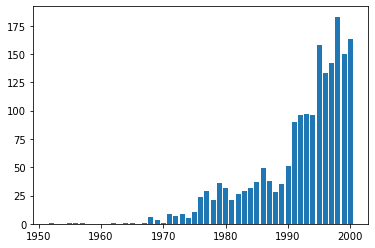

In [37]:
plt.bar(device_pub_year_table.index, [device_pub_year_table.get(x) for x in device_pub_year_table.index])

### For Export to Voyant Tools

In [38]:
def voyant_export(year_group, dataset_name, start_year, end_year=2000):
    year_title_list = year_group["Title"].unique()
    
    for year in range(start_year, end_year + 1):
        temp_list = []
        try:
            for title in year_title_list[year]:
                title = title.replace("--", " ")
                title = title + "\n"
                temp_list.append(title)
            
            with open("Title Data Files/med_dev/{}_{}.txt".format(year, dataset_name), "w") as f:
                f.writelines(temp_list)
       
        except KeyError:  # If there were no publication in a year in the range
            pass
    
    print("Data Exported")

Medical Device Publication Word Frequency: https://voyant-tools.org/?corpus=fa33b04ff82a6bb8eb2bb7c2b5c9837a&panels=corpusterms,termsberry,trends,summary,contexts

In [39]:
voyant_export(year_group = device_date_group, dataset_name="med_dev", start_year=1952, end_year=2000)

Data Exported


# Network Analysis

In [45]:
def get_author_info(pubmed_data, write_file):
    identifier_list = {}
    id_count = 1
    
    # Create data structure for author
    for i, paper in enumerate(pubmed_data["Authors"]):
        for author in paper:
            if author["name"] != None:
                
                # If author is already in the dictionary
                """There one instance were an author spells his name both 'Demets' and 'DiMets'"""
                if author["name"] in [item for item in identifier_list.keys()]:

                    # Update Values
                    identifier_list[author["name"]]["weight"] += 1
                    identifier_list[author["name"]]["Years Active"].append([pubmed_data["Date"][i]])      

                # If the author is not already in the dictionary
                else:
                    identifier_list[author["name"]]  = {"id": id_count, 
                                                        "Years Active":[pubmed_data["Date"][i]], 
                                                        "affiliation":[], "weight": 1, "edges":[]}

                # Get year/affiliation data for GIS
                if author["affiliation"] != None:
                    aff = author["affiliation"]
                    aff = re.sub(r"[^@ \t\r\n]+@[^@ \t\r\n]+\.[^@ \t\r\n]+", "", aff)  # Remove emails. Some author only list email.
                    aff = re.sub(r"(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()!@:%_\+.~#?&\/\/=]*)", "", aff)  # Remove websites
                    aff = aff.strip(" ")
                    if aff != "":  # For authors who only put an email as thier insitution
                        identifier_list[author["name"]]["affiliation"].append((aff, pubmed_data["Date"][i]))

                # Append other authors to edges list
                temp_list = [o_author["name"] for o_author in paper]
                for item in temp_list:
                    if item != author["name"]:
                        identifier_list[author["name"]]["edges"].append(item) 

                id_count +=1
            
    with open(write_file, "w") as f:
        json.dump(identifier_list, f, indent=4)

In [46]:
with open("device_pubmed_data.json", "r") as f:
    pubmed_data = json.load(f)
    get_author_info(pubmed_data=pubmed_data , write_file="device_author_data.json")

In [22]:
with open("device_author_data.json") as f:
    test = json.load(f)
    print(len(test))

4902


# Location Analysis

In [47]:
# Export location List
with open("device_author_data.json", "r") as f:
    auth_list = json.load(f)

# Need separte table for dates
i = 1
with open("./Statistical Data/institution_locations.csv", "w", encoding="utf-8", newline="") as csvfile: #In Arc: 21 addresses in the file could not be located.
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(["Index", "Location", "Year"])  # Headers
    for author in auth_list.values():
        if author["affiliation"] != []:
            inst = author["affiliation"]
            for item in inst:
                writer.writerow([i, item[0], eval(item[1]).year])
                i +=1